# Prueba algoritmos de optimización paper CE para problemas enteros


Importaciones y licencia


In [17]:
import os
import gurobipy as gp
import numpy as np
from gurobipy import GRB


lic_path = r"C:\Users\PC3\Desktop\gurobi.lic" 
os.environ["GRB_LICENSE_FILE"] = lic_path


algoritmo 

In [18]:
#CONJUNTO D
def D_box(m, v, lb, ub):
    n = len(lb)
    for i in range(n):
        m.addConstr(v[i] >= int(lb[i]), name=f"D_box_lb[{i}]")
        m.addConstr(v[i] <= int(ub[i]), name=f"D_box_ub[{i}]")

def add_l1_distance(model, a, b, c, a0, b0, c0):
    n = len(a0)

    da = []
    for i in range(n):
        ti = model.addVar(lb=0.0, name=f"da_abs[{i}]")
        model.addConstr(ti >= a[i] - float(a0[i]), name=f"da_pos[{i}]")
        model.addConstr(ti >= -(a[i] - float(a0[i])), name=f"da_neg[{i}]")
        da.append(ti)

    dc = []
    for i in range(n):
        ti = model.addVar(lb=0.0, name=f"dc_abs[{i}]")
        model.addConstr(ti >= c[i] - float(c0[i]), name=f"dc_pos[{i}]")
        model.addConstr(ti >= -(c[i] - float(c0[i])), name=f"dc_neg[{i}]")
        dc.append(ti)

    db = model.addVar(lb=0.0, name="db_abs")
    model.addConstr(db >= b - float(b0), name="db_pos")
    model.addConstr(db >= -(b - float(b0)), name="db_neg")

    return gp.quicksum(da) + db + gp.quicksum(dc)

#solver de problema de separacion
def solve_separation(a_hat, b_hat, c_hat, U=None):
    n = len(a_hat)
    m = gp.Model("separation")
    m.Params.OutputFlag = 0
    m.Params.Threads = 1

    y = m.addVars(n, vtype=GRB.INTEGER, lb=0, name="y")

    if U is not None:
        for i in range(n):
            m.addConstr(y[i] <= int(U[i]), name=f"y_ub[{i}]")

    m.addConstr(gp.quicksum(float(a_hat[i]) * y[i] for i in range(n)) >= float(b_hat),
                name="aTy_ge_b")

    m.setObjective(gp.quicksum(float(c_hat[i]) * y[i] for i in range(n)), GRB.MINIMIZE)
    m.optimize()

    if m.Status != GRB.OPTIMAL:
        return m.Status, None, None

    y_star = np.array([y[i].X for i in range(n)], dtype=float)
    return GRB.OPTIMAL, y_star, float(m.ObjVal)


#creamos el problema maestro
def solve_master(Y, a0, b0, c0, H_bounds, M, U=None, D_lb=None, D_ub=None):
    n = len(a0)

    m = gp.Model("master")
    m.Params.OutputFlag = 0
    m.Params.Threads = 1

    a = m.addVars(n, name="a")
    c = m.addVars(n, name="c")
    b = m.addVar(lb=float(H_bounds["b_lb"]), ub=float(H_bounds["b_ub"]), name="b")

    for i in range(n):
        a[i].LB = float(H_bounds["a_lb"][i]); a[i].UB = float(H_bounds["a_ub"][i])
        c[i].LB = float(H_bounds["c_lb"][i]); c[i].UB = float(H_bounds["c_ub"][i])

    x = m.addVars(n, vtype=GRB.INTEGER, lb=0, name="x")

    if U is not None:
        for i in range(n):
            m.addConstr(x[i] <= int(U[i]), name=f"x_ub[{i}]")

    # x in D
    if D_lb is not None and D_ub is not None:
        D_box(m, x, D_lb, D_ub)

    # a^T x >= b
    m.addConstr(gp.quicksum(a[i] * x[i] for i in range(n)) >= b, name="aTx_ge_b")

    # cortes (10a)-(10c) para y in Y
    for k, yk in enumerate(Y):
        zk = m.addVar(vtype=GRB.BINARY, name=f"z[{k}]")

        lhs = gp.quicksum(c[i] * x[i] for i in range(n))
        rhs = gp.quicksum(float(yk[i]) * c[i] for i in range(n)) + float(M) * zk
        m.addConstr(lhs <= rhs, name=f"10a[{k}]")

        aTy = gp.quicksum(float(yk[i]) * a[i] for i in range(n))
        m.addConstr(aTy >= b - float(M) * zk, name=f"10b[{k}]")
        m.addConstr(aTy <= b - 1 + float(M) * (1 - zk), name=f"10c[{k}]")

    delta_expr = add_l1_distance(m, [a[i] for i in range(n)], b, [c[i] for i in range(n)], a0, b0, c0)
    m.setObjective(delta_expr, GRB.MINIMIZE)
    m.optimize()

    if m.Status != GRB.OPTIMAL:
        return m.Status, None

    sol = {
        "a": np.array([a[i].X for i in range(n)], float),
        "b": float(b.X),
        "c": np.array([c[i].X for i in range(n)], float),
        "x": np.array([x[i].X for i in range(n)], float),
        "delta": float(m.ObjVal),
    }
    return GRB.OPTIMAL, sol

#luego creamos el algoritmo:
import time

def algorithm4(a0, b0, c0, H_bounds, M, U=None, D_lb=None, D_ub=None, tol=1e-6, time_limit_seconds=120):
    Y = []
    seen = set()
    t0 = time.time()
    it = 0

    while True:
        if time.time() - t0 > time_limit_seconds:
            return {"status": "TIME_LIMIT", "Y": Y, "iters": it}

        it += 1
        st, sol = solve_master(Y, a0, b0, c0, H_bounds, M, U=U, D_lb=D_lb, D_ub=D_ub)
        if st != GRB.OPTIMAL:
            return {"status": st, "message": "Master infeasible/not optimal", "Y": Y, "iters": it}

        a_hat, b_hat, c_hat, x_hat = sol["a"], sol["b"], sol["c"], sol["x"]

        st2, y_hat, cy = solve_separation(a_hat, b_hat, c_hat, U=U)
        if st2 != GRB.OPTIMAL:
            return {"status": st2, "message": "Separation infeasible/not optimal", "Y": Y, "iters": it}

        cx = float(np.dot(c_hat, x_hat))

        # termina: x_hat ya es óptimo vs todos los factibles
        if not (cy < cx - tol):
            return {"status": GRB.OPTIMAL, "sol": sol, "Y": Y, "iters": it}

        # evita agregar el mismo y infinitamente
        y_key = tuple(int(round(v)) for v in y_hat)
        if y_key in seen:
            return {"status": "CYCLE_DETECTED", "sol": sol, "Y": Y, "iters": it}

        seen.add(y_key)
        Y.append(y_hat)



ejecucion del algoritmo

In [19]:
n = 3
a0 = np.random.randint(1, 11, size=n)
c0 = np.random.randint(1, 11, size=n)
b0 = np.random.randint(1, 100)
bmax = 30
H_bounds = {
    "a_lb": np.ones(n),
    "a_ub": np.ones(n) * 10,
    "c_lb": np.ones(n),
    "c_ub": np.ones(n) * 10,
    "b_lb": 10,
    "b_ub": 100
}

U = np.ones(n) * 10

D_lb = np.ones(n)
D_ub = np.ones(n) * 4
D_lb[:(n//3)] = 0
D_ub[:(n//3)] = 0

M = 10000

res = algorithm4(a0, b0, c0, H_bounds, M, U=U, D_lb=D_lb, D_ub=D_ub, time_limit_seconds=6000)
print(res["status"])
print(res.get("sol"))

2
{'a': array([ 1.9, 10. , 10. ]), 'b': 80.0, 'c': array([1.5, 9. , 9. ]), 'x': array([0., 4., 4.]), 'delta': 9.6}


verificacion de solucion

In [20]:
def solve_P_choose_argmin_in_D(a_hat, b_hat, c_hat, U=None, D_lb=None, D_ub=None):
    """
    1) Resuelve P(a_hat,b_hat,c_hat) sobre X (sin D) para obtener opt_val.
    2) Fija c^T x = opt_val y AHÍ impone D_box para elegir un argmin dentro de D (si existe).

    X: x in Z_{>=0}^n, y opcionalmente x<=U.
    D: D_lb <= x <= D_ub (si se entrega).
    """
    n = len(a_hat)

    m = gp.Model("P_hat")
    m.Params.OutputFlag = 0
    m.Params.Threads = 1

    # X: x in Z^n, x >= 0
    x = m.addVars(n, vtype=GRB.INTEGER, lb=0, name="x")

    if U is not None:
        for i in range(n):
            m.addConstr(x[i] <= int(U[i]), name=f"x_ub[{i}]")

    # factibilidad: a^T x >= b
    m.addConstr(gp.quicksum(float(a_hat[i]) * x[i] for i in range(n)) >= float(b_hat),
                name="aTx_ge_b")

    # 1) objetivo principal
    obj1 = gp.quicksum(float(c_hat[i]) * x[i] for i in range(n))
    m.setObjective(obj1, GRB.MINIMIZE)
    m.optimize()

    if m.Status != GRB.OPTIMAL:
        return m.Status, None, None

    opt_val = float(m.ObjVal)

    # 2) quedarse en el conjunto de óptimos
    m.addConstr(obj1 == opt_val, name="fix_optimal_value")

    # imponer D SOLO para elegir el argmin dentro de D
    if D_lb is not None and D_ub is not None:
        for i in range(n):
            m.addConstr(x[i] >= int(D_lb[i]), name=f"D_lb[{i}]")
            m.addConstr(x[i] <= int(D_ub[i]), name=f"D_ub[{i}]")

    # objetivo secundario: cualquiera (0 sirve)
    m.setObjective(0, GRB.MINIMIZE)
    m.optimize()

    if m.Status == GRB.INFEASIBLE:
        return GRB.INFEASIBLE, None, opt_val

    x_star = np.array([x[i].X for i in range(n)], dtype=float)
    return GRB.OPTIMAL, x_star, opt_val

sol = res["sol"]
a_hat, b_hat, c_hat = sol["a"], sol["b"], sol["c"]

st, x_star, opt = solve_P_choose_argmin_in_D(
    a_hat, b_hat, c_hat,
    U=U,
    D_lb=D_lb,
    D_ub=D_ub
)

print("status:", st)   # 2 = GRB.OPTIMAL
print("x*:", x_star)
print("opt:", opt)


status: 2
x*: [0. 4. 4.]
opt: 72.0


benchmark


n  status    
3  2             50
4  2             45
   TIME_LIMIT     5
5  2             31
   TIME_LIMIT    19
6  2             23
   TIME_LIMIT    27
7  2             18
   TIME_LIMIT    32
dtype: int64
   n  count_total  count_optimal  count_verified_ok  count_time_limit  \
0  3         50.0           50.0               50.0               0.0   
1  4         50.0           45.0               45.0               5.0   
2  5         50.0           31.0               31.0              19.0   
3  6         50.0           23.0               23.0              27.0   
4  7         50.0           18.0               18.0              32.0   

   pct_time_limit  mean_finished_sec  std_finished_sec  mean_censored_sec  \
0            0.00           0.504122          1.418828           0.504122   
1            0.10          23.009514         58.319949          50.708563   
2            0.38          53.035994         84.732271         146.882316   
3            0.54          39.783313         7

C:\Users\PC3\AppData\Local\Temp\ipykernel_12216\2437967679.py:203: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby("n").apply(agg).reset_index()


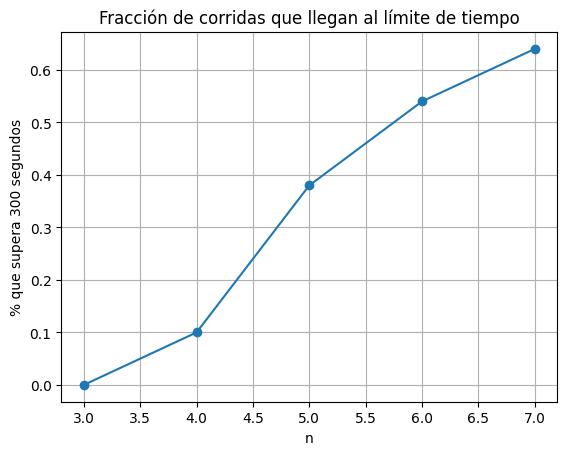

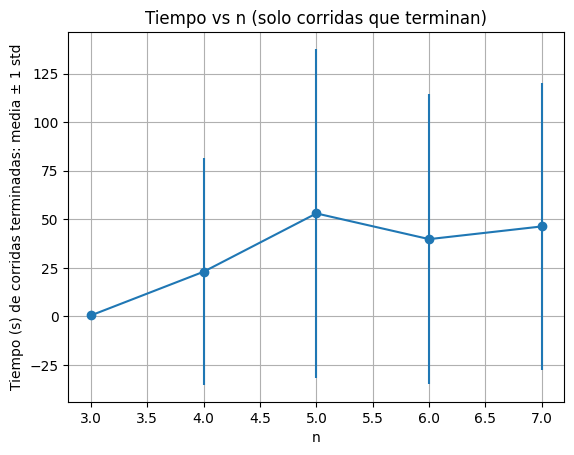

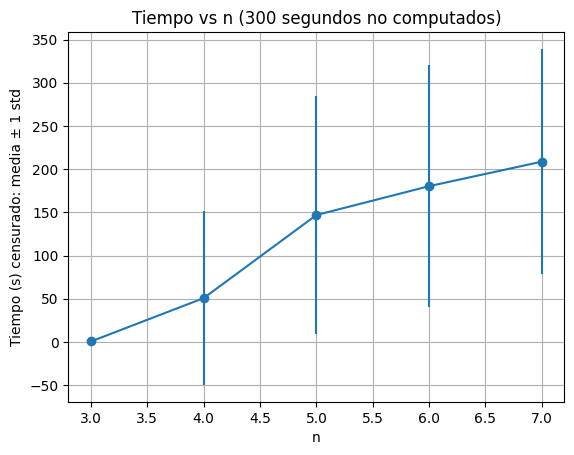

In [21]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Helpers: instancia aleatoria
# -----------------------------
def sample_instance(n, rng):
    
    #conjunto D
    D_lb = np.ones(n)
    D_ub = np.ones(n) * 10
    D_lb[: (n // 3)] = 0
    D_ub[: (n // 3)] = 0

    U = np.ones(n) * 100

    a0 = rng.integers(1, 11, size=n)
    c0 = rng.integers(1, 11, size=n)
    bmax = int(np.dot(a0, D_ub))           # máximo posible de a0^T x con D_lb<=x<=D_ub, para que exista un x en D factible
    b0 = int(rng.integers(1, min(100, bmax + 1)))

    H_bounds = {
        "a_lb": np.ones(n),
        "a_ub": np.ones(n) * 10,
        "c_lb": np.ones(n),
        "c_ub": np.ones(n) * 10,
        "b_lb": 1,
        "b_ub": b0*10
    }
    
    U = np.ones(n) * 100

    # Tu ejemplo: D fija primeros n//3 en 0
    

    return a0, b0, c0, H_bounds, U, D_lb, D_ub


# ---------------------------------------
# Verificador: compara vs P(a_hat,b_hat,c_hat)
# ---------------------------------------
def verify_solution(sol, U=None, D_lb=None, D_ub=None, tol=1e-6):
    """
    Retorna dict con checks básicos:
    - feas: a^T x >= b
    - in_D: x en caja D
    - matches_global_opt: c^T x == opt_val de P_hat (sobre X sin D)
    - exists_opt_in_D: si el óptimo global admite un representante en D
    """
    a_hat, b_hat, c_hat, x_hat = sol["a"], sol["b"], sol["c"], sol["x"]

    # Checks directos
    feas = float(np.dot(a_hat, x_hat)) >= float(b_hat) - 1e-9

    in_D = True
    if D_lb is not None and D_ub is not None:
        in_D = np.all(x_hat >= D_lb - 1e-9) and np.all(x_hat <= D_ub + 1e-9)

    cx = float(np.dot(c_hat, x_hat))

    # Resolver P_hat y comparar óptimo
    stP, x_star, opt_val = solve_P_choose_argmin_in_D(
        a_hat, b_hat, c_hat,
        U=U, D_lb=D_lb, D_ub=D_ub
    )

    matches_global_opt = False
    exists_opt_in_D = False

    if stP == GRB.OPTIMAL:
        matches_global_opt = (abs(cx - opt_val) <= tol * (1.0 + abs(opt_val)))
        exists_opt_in_D = True
    elif stP == GRB.INFEASIBLE:
        # significa: hay óptimo global en X, pero ninguno de esos óptimos cae en D
        # (tu función devuelve INFEASIBLE en la segunda fase)
        matches_global_opt = (abs(cx - opt_val) <= tol * (1.0 + abs(opt_val)))
        exists_opt_in_D = False
    else:
        # Algo raro: no óptimo / error
        return {
            "ok": False,
            "feas": feas,
            "in_D": in_D,
            "cx": cx,
            "opt_val": opt_val,
            "matches_global_opt": False,
            "exists_opt_in_D": False,
            "status_P": stP
        }

    ok = feas and in_D and matches_global_opt and exists_opt_in_D

    return {
        "ok": ok,
        "feas": feas,
        "in_D": in_D,
        "cx": cx,
        "opt_val": opt_val,
        "matches_global_opt": matches_global_opt,
        "exists_opt_in_D": exists_opt_in_D,
        "status_P": stP,
        "x_star": x_star
    }


# ---------------------------------------
# Un experimento: corre algorithm4 y mide tiempo
# ---------------------------------------
def run_one_trial(n, seed, M=10000, alg_time_limit=120, tol=1e-6):
    rng = np.random.default_rng(seed)
    a0, b0, c0, H_bounds, U, D_lb, D_ub = sample_instance(n, rng)

    t_start = time.perf_counter()
    res = algorithm4(
        a0, b0, c0, H_bounds, M,
        U=U, D_lb=D_lb, D_ub=D_ub,
        tol=tol,
        time_limit_seconds=alg_time_limit
    )
    t_end = time.perf_counter()

    runtime = t_end - t_start
    status = res.get("status", None)

    out = {
        "n": n,
        "seed": seed,
        "runtime_sec": runtime,
        "time_limit_sec": alg_time_limit,
        "hit_time_limit": (status == "TIME_LIMIT"),
        "status": status,
        "iters": res.get("iters", None),
        "verified_ok": False,
        "verify_feas": None,
        "verify_in_D": None,
        "verify_matches_global_opt": None,
        "verify_exists_opt_in_D": None,
    }

    if status == GRB.OPTIMAL and "sol" in res and res["sol"] is not None:
        v = verify_solution(res["sol"], U=U, D_lb=D_lb, D_ub=D_ub, tol=1e-6)
        out.update({
            "verified_ok": bool(v["ok"]),
            "verify_feas": v["feas"],
            "verify_in_D": v["in_D"],
            "verify_matches_global_opt": v["matches_global_opt"],
            "verify_exists_opt_in_D": v["exists_opt_in_D"],
        })

    return out


# ---------------------------------------
# Benchmark: varios n y varios trials
# ---------------------------------------
def benchmark(ns, trials_per_n=20, base_seed=123, M=10000, alg_time_limit=120):
    rows = []
    seed = base_seed
    for n in ns:
        for _ in range(trials_per_n):
            rows.append(run_one_trial(n=n, seed=seed, M=M, alg_time_limit=alg_time_limit))
            seed += 1
    return pd.DataFrame(rows)


# ---------------------------------------
# Stats + ajuste Normal + test (opcional)
# ---------------------------------------
def summarize(df):
    def agg(g):
        n_total = len(g)
        n_opt = int((g["status"] == GRB.OPTIMAL).sum())
        n_ok = int(((g["status"] == GRB.OPTIMAL) & (g["verified_ok"] == True)).sum())
        n_tl = int((g["status"] == "TIME_LIMIT").sum())
        p_tl = n_tl / n_total if n_total else float("nan")

        # tiempos solo de los que terminaron (no TIME_LIMIT)
        finished = g[g["status"] != "TIME_LIMIT"]["runtime_sec"].to_numpy()
        mean_finished = float(np.mean(finished)) if len(finished) else float("nan")
        std_finished = float(np.std(finished, ddof=1)) if len(finished) >= 2 else float("nan")

        # media "censurada": a los TIME_LIMIT les imputo alg_time_limit
        tl = float(g["time_limit_sec"].iloc[0]) if "time_limit_sec" in g.columns else float("nan")
        censored = g["runtime_sec"].to_numpy().copy()
        censored[g["status"].to_numpy() == "TIME_LIMIT"] = tl
        mean_cens = float(np.mean(censored)) if len(censored) else float("nan")
        std_cens = float(np.std(censored, ddof=1)) if len(censored) >= 2 else float("nan")

        return pd.Series({
            "count_total": n_total,
            "count_optimal": n_opt,
            "count_verified_ok": n_ok,
            "count_time_limit": n_tl,
            "pct_time_limit": p_tl,
            "mean_finished_sec": mean_finished,
            "std_finished_sec": std_finished,
            "mean_censored_sec": mean_cens,
            "std_censored_sec": std_cens,
        })

    return df.groupby("n").apply(agg).reset_index()

def plot_summary(summary_df):
    summary_df = summary_df.sort_values("n")

    plt.figure()
    plt.plot(summary_df["n"], summary_df["pct_time_limit"], "o-")
    plt.xlabel("n")
    plt.ylabel("% que supera 300 segundos")
    plt.title("Fracción de corridas que llegan al límite de tiempo")
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.errorbar(summary_df["n"], summary_df["mean_finished_sec"], yerr=summary_df["std_finished_sec"], fmt="o-")
    plt.xlabel("n")
    plt.ylabel("Tiempo (s) de corridas terminadas: media ± 1 std")
    plt.title("Tiempo vs n (solo corridas que terminan)")
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.errorbar(summary_df["n"], summary_df["mean_censored_sec"], yerr=summary_df["std_censored_sec"], fmt="o-")
    plt.xlabel("n")
    plt.ylabel("Tiempo (s) censurado: media ± 1 std")
    plt.title("Tiempo vs n (300 segundos no computados)")
    plt.grid(True)
    plt.show()


from concurrent.futures import ThreadPoolExecutor, as_completed
import os
import pandas as pd

def run_one_trial_wrapper(args):
    n, seed, M, alg_time_limit = args
    return run_one_trial(n=n, seed=seed, M=M, alg_time_limit=alg_time_limit)

def benchmark_threads(ns, trials_per_n=20, base_seed=123, M=10000, alg_time_limit=120, max_workers=None):
    jobs = []
    seed = base_seed
    for n in ns:
        for _ in range(trials_per_n):
            jobs.append((n, seed, M, alg_time_limit))
            seed += 1

    if max_workers is None:
        # regla conservadora para no matar el PC
        max_workers = max(1, (os.cpu_count() or 2) // 2)

    rows = []
    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        futs = [ex.submit(run_one_trial_wrapper, j) for j in jobs]
        for f in as_completed(futs):
            rows.append(f.result())

    return pd.DataFrame(rows)

ns = [3,4,5,6,7]
df_runs = benchmark_threads(ns, trials_per_n=50, max_workers=2, alg_time_limit=300)

print(df_runs.groupby(["n","status"]).size())

summary_df = summarize(df_runs)
print(summary_df)

plot_summary(summary_df)
